In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lsay-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5181295%2F8650027%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240904%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240904T211618Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D27b01c8381f0bb343b64dc8faf8fbaa59fa926a36b831a72b951c6b97e0fdb9509ca55548bc55fa1d69352874a80c9dbe7ceafe39c5359a7a22e855e77922c08cae161226fa0f13bcdae05b72c3cff71fdc81a36afecd45f54e44d9679b01c4955b5b233aadbe695bee86fc650d56b932648ce81a177c6833d4b8aab63ab1640bb686f53ff4aab4e4391b424824430426c4da367e7d0866b70c6c45d716341cf2276453fcab8aba27ec471af8a2e1f6dd2f8b1730b82a5b1a539af942359ca79b6024fec5ee6e436817fb3b6a26bc918f2313a0b4e64d1b03e21ff3e097af77a8569c2a84067dffd13313a6a2418eeb489b16399ba9401fa77dd51ba73e89ac8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 21037645 bytes downloaded
Downloaded and uncompressed: lsay-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lsay-dataset/30263-0001-Data.csv


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Assuming data is loaded into a DataFrame called df
# Extract the relevant variables for fall and spring semesters
df = pd.read_csv('/kaggle/input/lsay-dataset/30263-0001-Data.csv')
fall_variables = [
    'IAMTH1C', 'IAMTH1D', 'IAMTH2C', 'IAMTH2D', 'IASCI1C', 'IASCI1D',
    'IASCI2C', 'IAENG1C', 'IAENG2C', 'IASSTC', 'IACOMC', 'IAFORC',
    'IAARTC', 'IAMUSC', 'IAVOCC','IAVOCD', 'IA6A', 'IA6B', 'IA8B', 'IA8D',
    'IA8E', 'IA26ATXT', 'IA26C', 'IA15B', 'IA15C', 'IA15D', 'IA37A',
    'IA37D', 'IA37J', 'IA38A', 'IA38D', 'IA38J'
]

spring_variables = [
    'JAMTH2C', 'JASCI1C', 'JASCI2C', 'JAENG1C', 'JAENG2C', 'JASSTC',
    'JACOMC', 'JAFORC', 'JAARTC', 'JAMUSC', 'JAVOCC','JAVOCD', 'JA9ATXT', 'JA9C',
    'JC3B', 'JC3D', 'JC3E'
]

# Encode categorical variables
label_encoder = LabelEncoder()
for col in fall_variables + spring_variables + ['LAMAJOR8I']:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Split into features and target variable
X_fall = df[fall_variables]
y_fall = df['LAMAJOR8I']

X_spring = df[spring_variables]
y_spring = df['LAMAJOR8I']

# Standardize the features
scaler = StandardScaler()
X_fall = scaler.fit_transform(X_fall)
X_spring = scaler.fit_transform(X_spring)

# Train-test split
X_fall_train, X_fall_test, y_fall_train, y_fall_test = train_test_split(X_fall, y_fall, test_size=0.3, random_state=42)
X_spring_train, X_spring_test, y_spring_train, y_spring_test = train_test_split(X_spring, y_spring, test_size=0.3, random_state=42)


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train Random Forest for Fall Semester
model_fall = RandomForestClassifier(random_state=42)
model_fall.fit(X_fall_train, y_fall_train)

# Train Random Forest for Spring Semester
model_spring = RandomForestClassifier(random_state=42)
model_spring.fit(X_spring_train, y_spring_train)


RandomForestClassifier(random_state=42)

Fall Semester Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.54      0.95      0.69       862
           2       0.17      0.10      0.12        51
           3       0.00      0.00      0.00       177
           4       0.00      0.00      0.00        10
           5       0.29      0.07      0.12        67
           6       0.00      0.00      0.00         9
           7       0.33      0.09      0.14        79
           8       0.22      0.02      0.04        86
           9       0.25      0.03      0.05       112
          10       0.29      0.17      0.21       219
          11       0.28      0.07      0.12       109

    accuracy                           0.49      1784
   macro avg       0.20      0.13      0.12      1784
weighted avg       0.37      0.49      0.38      1784



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


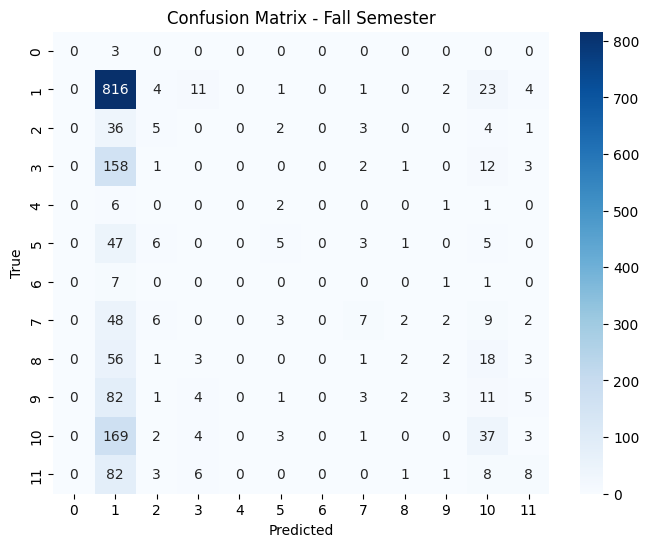

Spring Semester Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.57      0.88      0.69       862
           2       0.09      0.04      0.05        51
           3       0.12      0.06      0.08       177
           4       0.00      0.00      0.00        10
           5       0.11      0.03      0.05        67
           6       0.00      0.00      0.00         9
           7       0.19      0.05      0.08        79
           8       0.24      0.10      0.15        86
           9       0.19      0.05      0.08       112
          10       0.29      0.24      0.26       219
          11       0.14      0.06      0.09       109

    accuracy                           0.48      1784
   macro avg       0.16      0.13      0.13      1784
weighted avg       0.37      0.48      0.40      1784



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


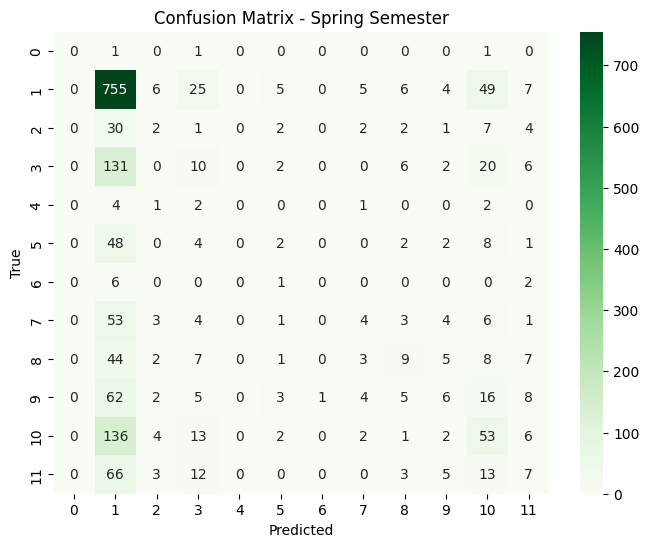

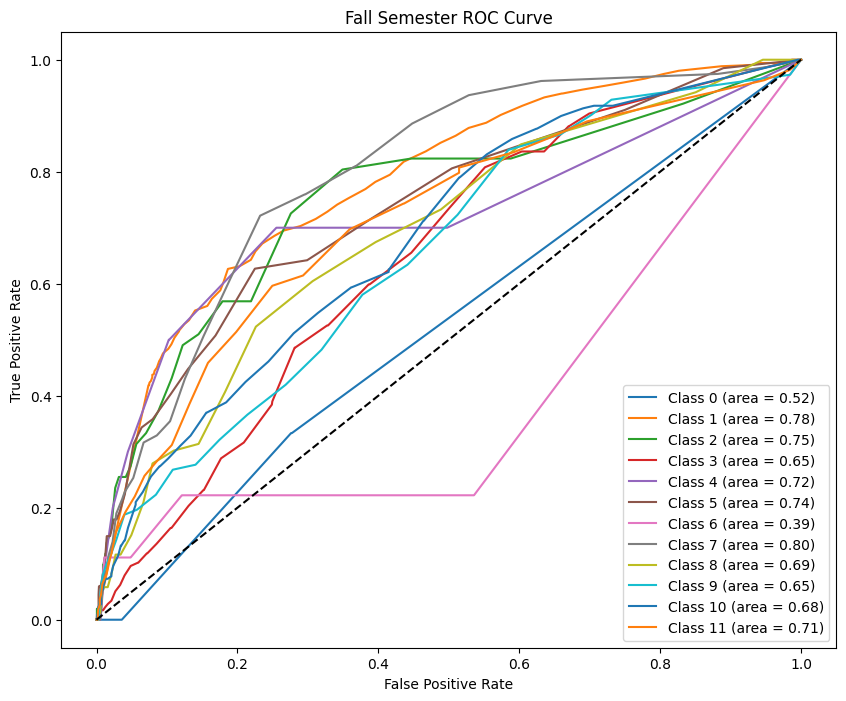

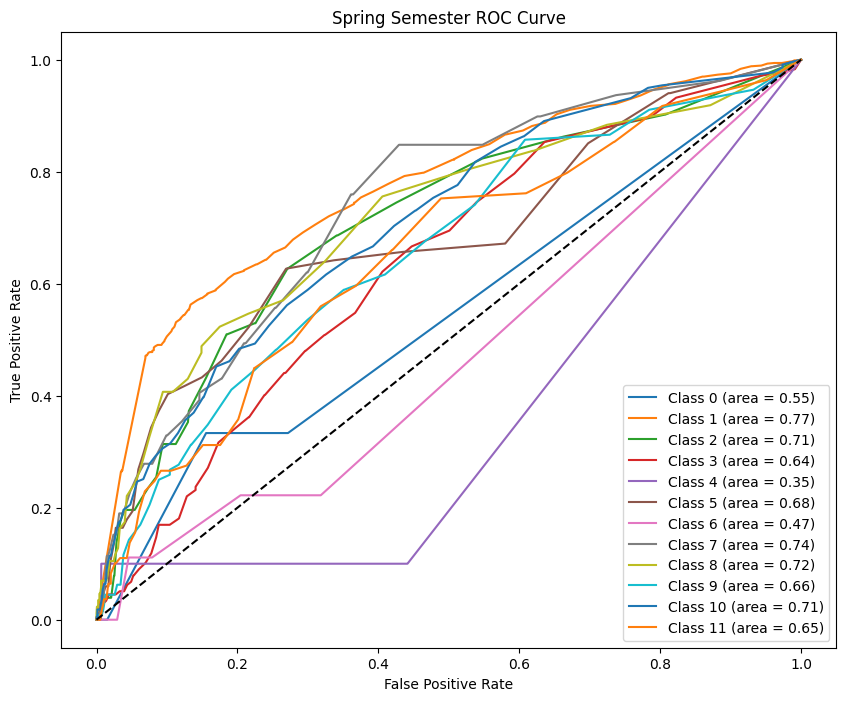

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Fall Semester Evaluation
y_fall_pred = model_fall.predict(X_fall_test)
print("Fall Semester Classification Report")
print(classification_report(y_fall_test, y_fall_pred))

# Confusion Matrix for Fall
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_fall_test, y_fall_pred), annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - Fall Semester')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Spring Semester Evaluation
y_spring_pred = model_spring.predict(X_spring_test)
print("Spring Semester Classification Report")
print(classification_report(y_spring_test, y_spring_pred))

# Confusion Matrix for Spring
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_spring_test, y_spring_pred), annot=True, fmt="d", cmap="Greens")
plt.title('Confusion Matrix - Spring Semester')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curves for both semesters

# Binarize labels for multi-class ROC
from sklearn.preprocessing import label_binarize
n_classes = len(df['LAMAJOR8I'].unique())
y_fall_test_binarized = label_binarize(y_fall_test, classes=range(n_classes))
y_spring_test_binarized = label_binarize(y_spring_test, classes=range(n_classes))

# ROC Curve and AUC for Fall Semester
fpr_fall, tpr_fall, roc_auc_fall = dict(), dict(), dict()
for i in range(n_classes):
    fpr_fall[i], tpr_fall[i], _ = roc_curve(y_fall_test_binarized[:, i], model_fall.predict_proba(X_fall_test)[:, i])
    roc_auc_fall[i] = auc(fpr_fall[i], tpr_fall[i])

# Plot ROC Curve for Fall
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_fall[i], tpr_fall[i], label=f'Class {i} (area = {roc_auc_fall[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Fall Semester ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# ROC Curve and AUC for Spring Semester
fpr_spring, tpr_spring, roc_auc_spring = dict(), dict(), dict()
for i in range(n_classes):
    fpr_spring[i], tpr_spring[i], _ = roc_curve(y_spring_test_binarized[:, i], model_spring.predict_proba(X_spring_test)[:, i])
    roc_auc_spring[i] = auc(fpr_spring[i], tpr_spring[i])

# Plot ROC Curve for Spring
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_spring[i], tpr_spring[i], label=f'Class {i} (area = {roc_auc_spring[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Spring Semester ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


Fall Semester Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.54      0.94      0.69       862
           2       0.22      0.15      0.17       219
           3       0.33      0.10      0.15       109
           4       0.12      0.08      0.10        51
           5       0.17      0.02      0.03       177
           6       0.00      0.00      0.00        10
           7       0.38      0.09      0.14        67
           8       0.00      0.00      0.00         9
           9       0.33      0.04      0.07        79
          10       0.50      0.06      0.10        86
          11       0.33      0.03      0.05       112

    accuracy                           0.49      1784
   macro avg       0.24      0.12      0.13      1784
weighted avg       0.40      0.49      0.38      1784



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


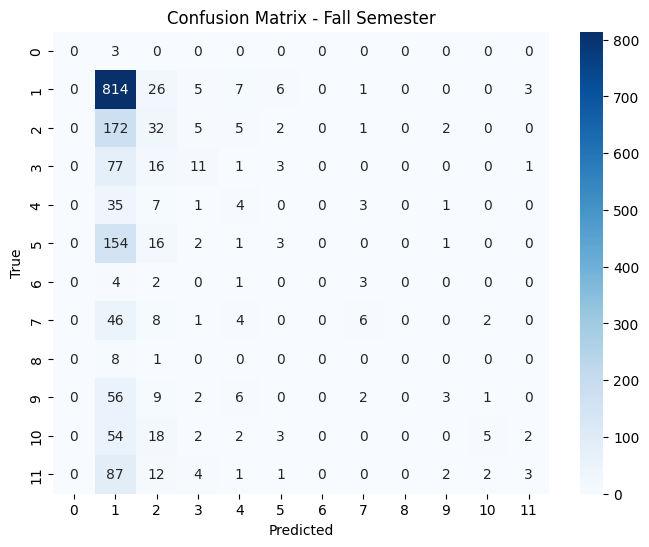

Spring Semester Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.56      0.87      0.68       862
           2       0.28      0.23      0.25       219
           3       0.18      0.08      0.11       109
           4       0.09      0.04      0.05        51
           5       0.15      0.07      0.10       177
           6       0.00      0.00      0.00        10
           7       0.15      0.04      0.07        67
           8       0.00      0.00      0.00         9
           9       0.26      0.08      0.12        79
          10       0.23      0.08      0.12        86
          11       0.15      0.04      0.07       112

    accuracy                           0.47      1784
   macro avg       0.17      0.13      0.13      1784
weighted avg       0.37      0.47      0.40      1784



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


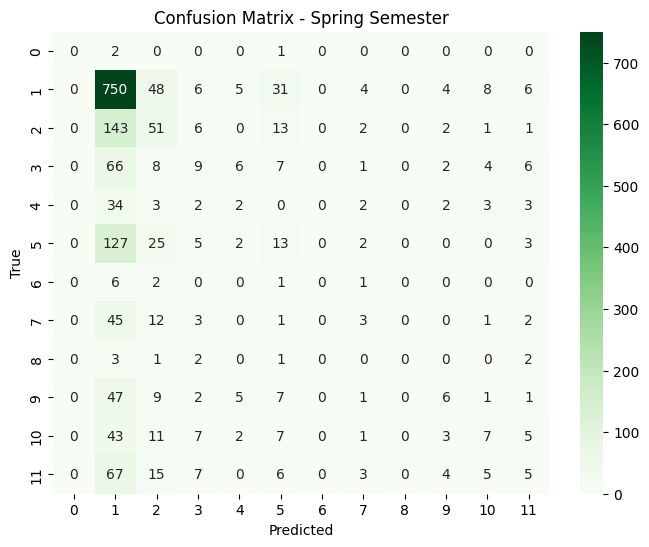

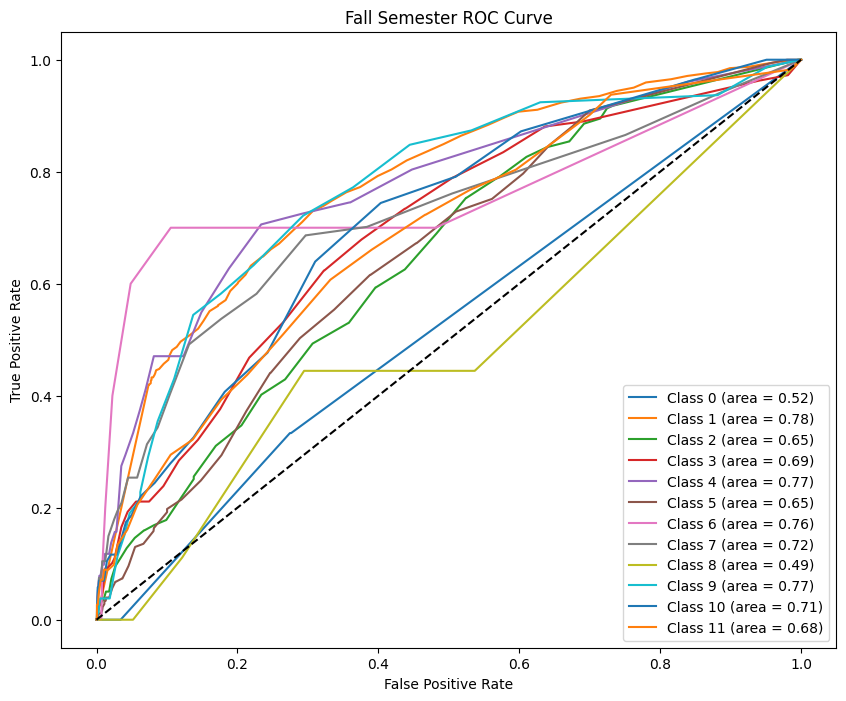

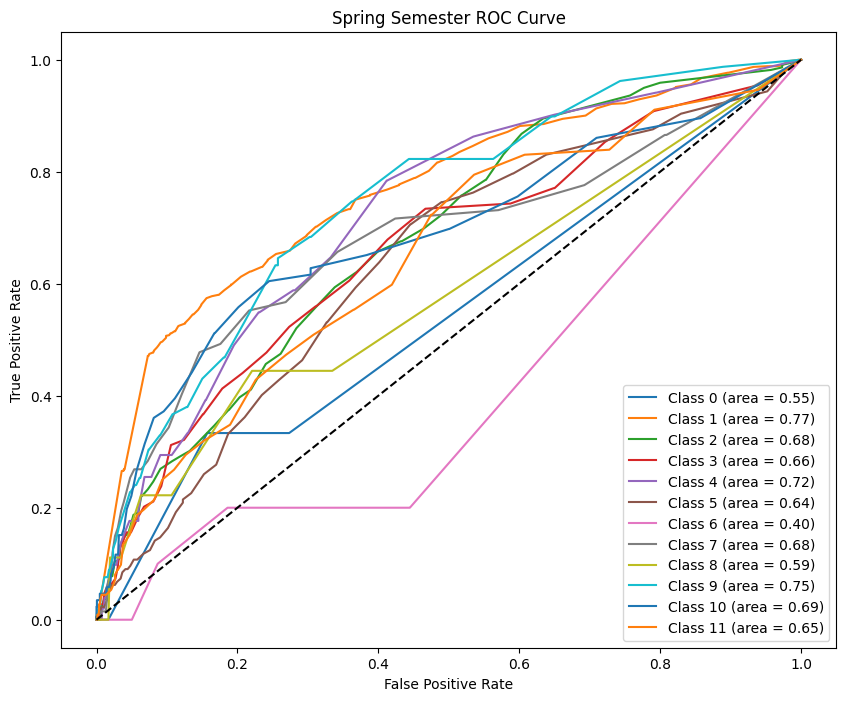

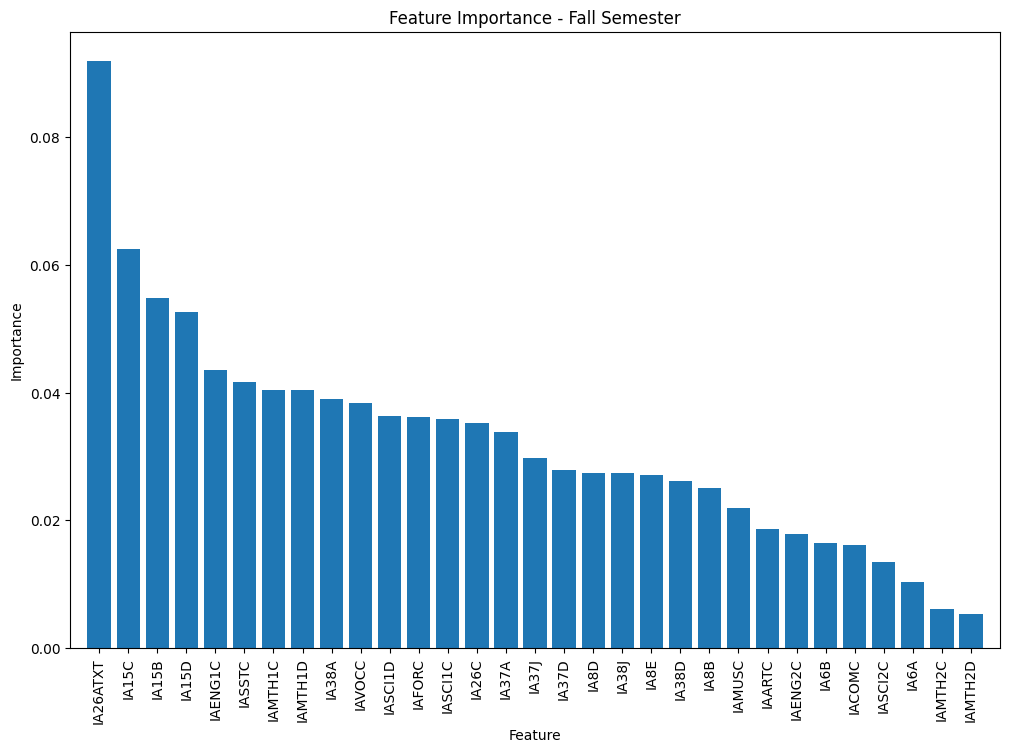

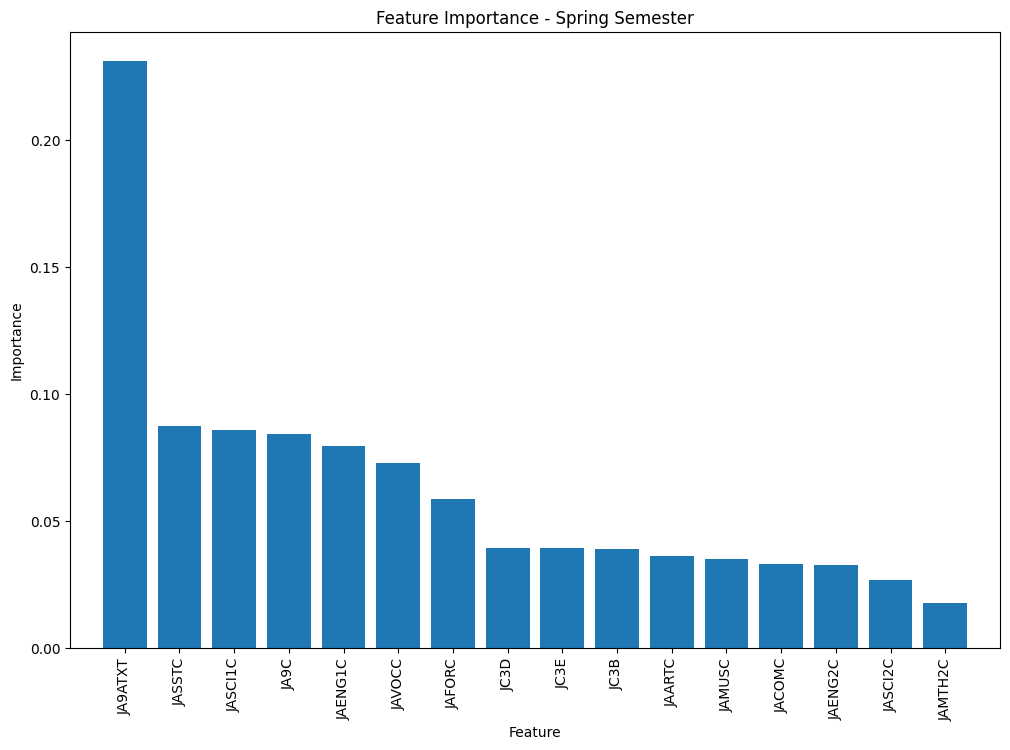

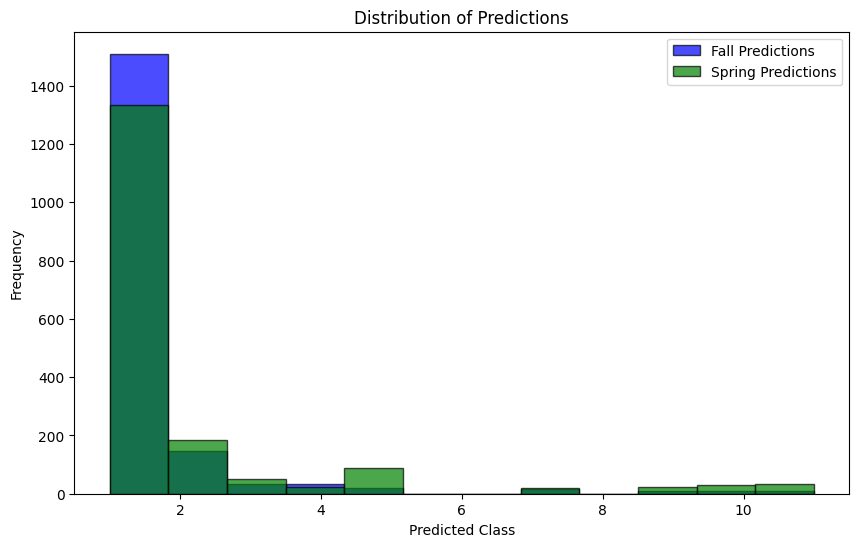

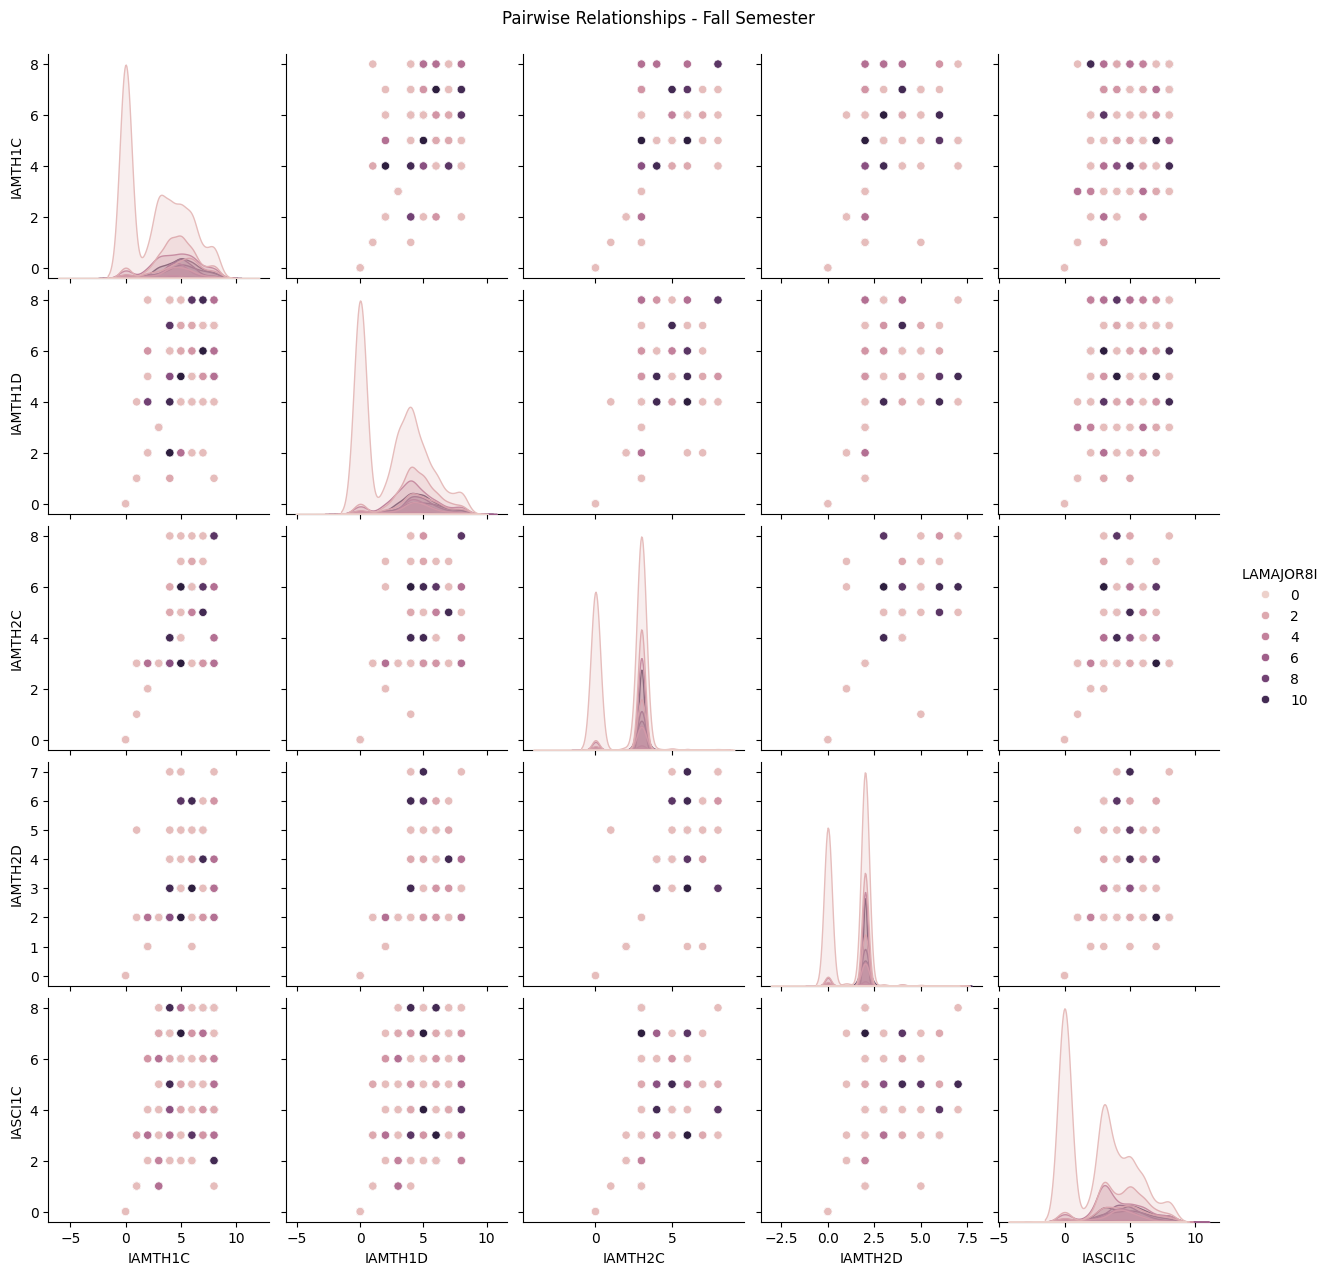

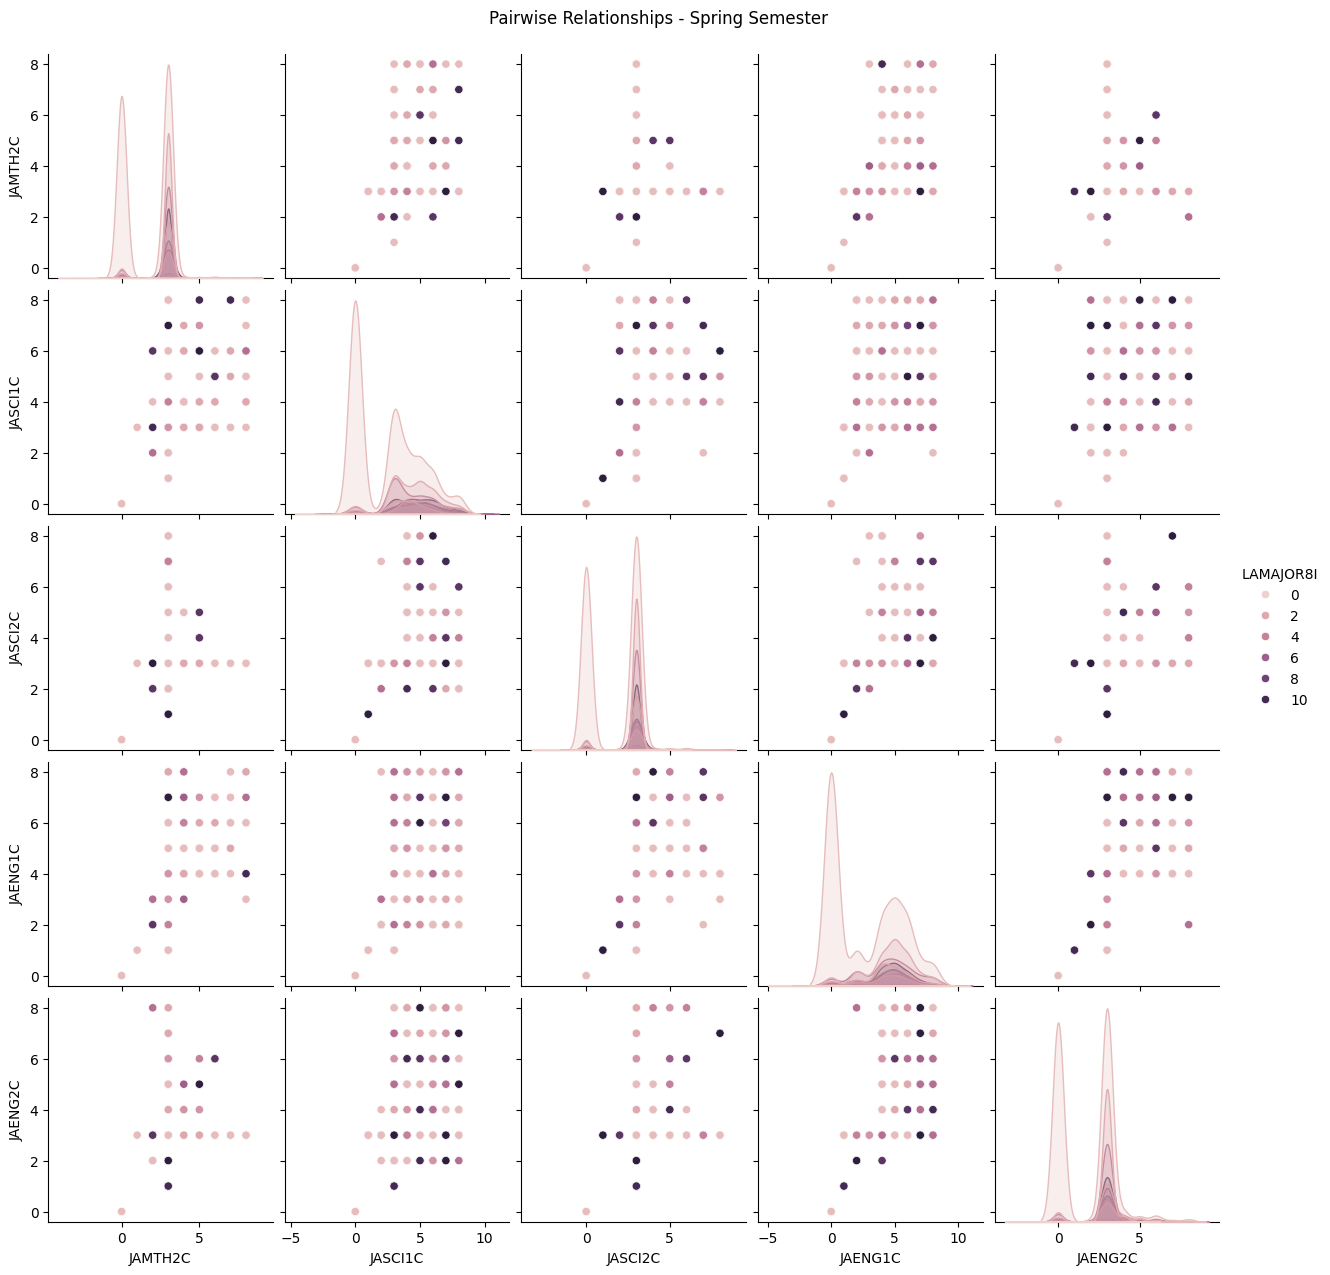

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data into a DataFrame df (assumed to be done)

# Define fall and spring variables
fall_variables = [
    'IAMTH1C', 'IAMTH1D', 'IAMTH2C', 'IAMTH2D',
    'IASCI1C', 'IASCI1D', 'IASCI2C',
    'IAENG1C', 'IAENG2C', 'IASSTC',
    'IACOMC', 'IAFORC', 'IAARTC', 'IAMUSC', 'IAVOCC',
    'IA6A', 'IA6B', 'IA8B', 'IA8D', 'IA8E',
    'IA26ATXT', 'IA26C', 'IA15B', 'IA15C', 'IA15D',
    'IA37A', 'IA37D', 'IA37J', 'IA38A', 'IA38D', 'IA38J'
]
spring_variables = [
    'JAMTH2C', 'JASCI1C', 'JASCI2C',
    'JAENG1C', 'JAENG2C', 'JASSTC',
    'JACOMC', 'JAFORC', 'JAARTC', 'JAMUSC', 'JAVOCC',
    'JA9ATXT', 'JA9C', 'JC3B', 'JC3D', 'JC3E'
]

# Encode categorical variables
label_encoder = LabelEncoder()
for col in fall_variables + spring_variables + ['LAMAJOR8I']:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Split into features and target variable
X_fall = df[fall_variables]
y_fall = df['LAMAJOR8I']
X_spring = df[spring_variables]
y_spring = df['LAMAJOR8I']

# Standardize the features
scaler = StandardScaler()
X_fall = scaler.fit_transform(X_fall)
X_spring = scaler.fit_transform(X_spring)

# Train-test split
X_fall_train, X_fall_test, y_fall_train, y_fall_test = train_test_split(X_fall, y_fall, test_size=0.3, random_state=42)
X_spring_train, X_spring_test, y_spring_train, y_spring_test = train_test_split(X_spring, y_spring, test_size=0.3, random_state=42)

# Train Random Forest for Fall Semester
model_fall = RandomForestClassifier(random_state=42)
model_fall.fit(X_fall_train, y_fall_train)

# Train Random Forest for Spring Semester
model_spring = RandomForestClassifier(random_state=42)
model_spring.fit(X_spring_train, y_spring_train)

# Fall Semester Evaluation
y_fall_pred = model_fall.predict(X_fall_test)
print("Fall Semester Classification Report")
print(classification_report(y_fall_test, y_fall_pred))

# Confusion Matrix for Fall
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_fall_test, y_fall_pred), annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - Fall Semester')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Spring Semester Evaluation
y_spring_pred = model_spring.predict(X_spring_test)
print("Spring Semester Classification Report")
print(classification_report(y_spring_test, y_spring_pred))

# Confusion Matrix for Spring
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_spring_test, y_spring_pred), annot=True, fmt="d", cmap="Greens")
plt.title('Confusion Matrix - Spring Semester')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curves for both semesters
from sklearn.preprocessing import label_binarize

n_classes = len(df['LAMAJOR8I'].unique())
y_fall_test_binarized = label_binarize(y_fall_test, classes=range(n_classes))
y_spring_test_binarized = label_binarize(y_spring_test, classes=range(n_classes))

# ROC Curve and AUC for Fall Semester
fpr_fall, tpr_fall, roc_auc_fall = dict(), dict(), dict()
for i in range(n_classes):
    fpr_fall[i], tpr_fall[i], _ = roc_curve(y_fall_test_binarized[:, i], model_fall.predict_proba(X_fall_test)[:, i])
    roc_auc_fall[i] = auc(fpr_fall[i], tpr_fall[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_fall[i], tpr_fall[i], label=f'Class {i} (area = {roc_auc_fall[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Fall Semester ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# ROC Curve and AUC for Spring Semester
fpr_spring, tpr_spring, roc_auc_spring = dict(), dict(), dict()
for i in range(n_classes):
    fpr_spring[i], tpr_spring[i], _ = roc_curve(y_spring_test_binarized[:, i], model_spring.predict_proba(X_spring_test)[:, i])
    roc_auc_spring[i] = auc(fpr_spring[i], tpr_spring[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_spring[i], tpr_spring[i], label=f'Class {i} (area = {roc_auc_spring[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Spring Semester ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Feature Importance Plot
importances_fall = model_fall.feature_importances_
indices_fall = np.argsort(importances_fall)[::-1]
feature_names_fall = [fall_variables[i] for i in indices_fall]

plt.figure(figsize=(12, 8))
plt.title('Feature Importance - Fall Semester')
plt.bar(range(X_fall.shape[1]), importances_fall[indices_fall], align='center')
plt.xticks(range(X_fall.shape[1]), feature_names_fall, rotation=90)
plt.xlim([-1, X_fall.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

importances_spring = model_spring.feature_importances_
indices_spring = np.argsort(importances_spring)[::-1]
feature_names_spring = [spring_variables[i] for i in indices_spring]

plt.figure(figsize=(12, 8))
plt.title('Feature Importance - Spring Semester')
plt.bar(range(X_spring.shape[1]), importances_spring[indices_spring], align='center')
plt.xticks(range(X_spring.shape[1]), feature_names_spring, rotation=90)
plt.xlim([-1, X_spring.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# Distribution of Predictions
plt.figure(figsize=(10, 6))
plt.hist(y_fall_pred, bins=n_classes, alpha=0.7, label='Fall Predictions', color='blue', edgecolor='black')
plt.hist(y_spring_pred, bins=n_classes, alpha=0.7, label='Spring Predictions', color='green', edgecolor='black')
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Class')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Pairwise Relationships
fall_subset = df[fall_variables].copy()
spring_subset = df[spring_variables].copy()
fall_subset['LAMAJOR8I'] = df['LAMAJOR8I']
spring_subset['LAMAJOR8I'] = df['LAMAJOR8I']

subset_features_fall = fall_variables[:5]  # Adjust subset as needed
subset_features_spring = spring_variables[:5]  # Adjust subset as needed

sns.pairplot(fall_subset[subset_features_fall + ['LAMAJOR8I']], hue='LAMAJOR8I')
plt.suptitle('Pairwise Relationships - Fall Semester', y=1.02)
plt.show()

sns.pairplot(spring_subset[subset_features_spring + ['LAMAJOR8I']], hue='LAMAJOR8I')
plt.suptitle('Pairwise Relationships - Spring Semester', y=1.02)
plt.show()



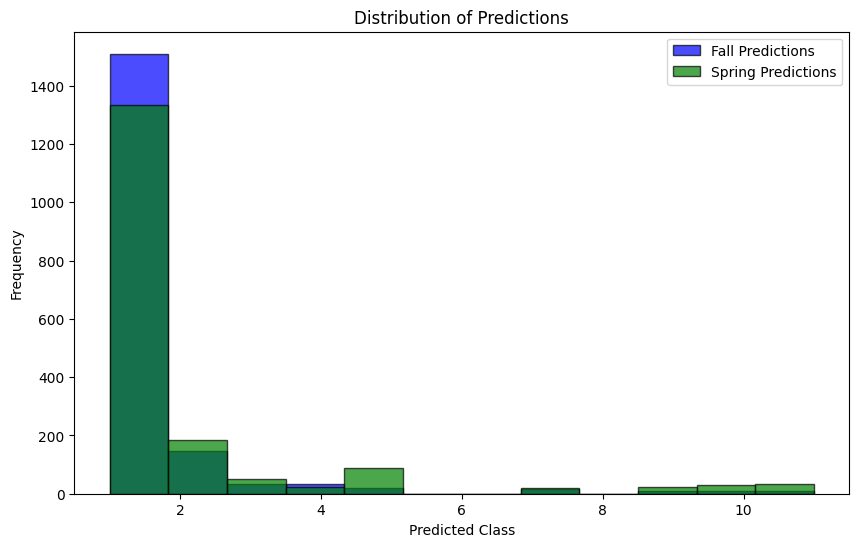

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(y_fall_pred, bins=n_classes, alpha=0.7, label='Fall Predictions', color='blue', edgecolor='black')
plt.hist(y_spring_pred, bins=n_classes, alpha=0.7, label='Spring Predictions', color='green', edgecolor='black')
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Class')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


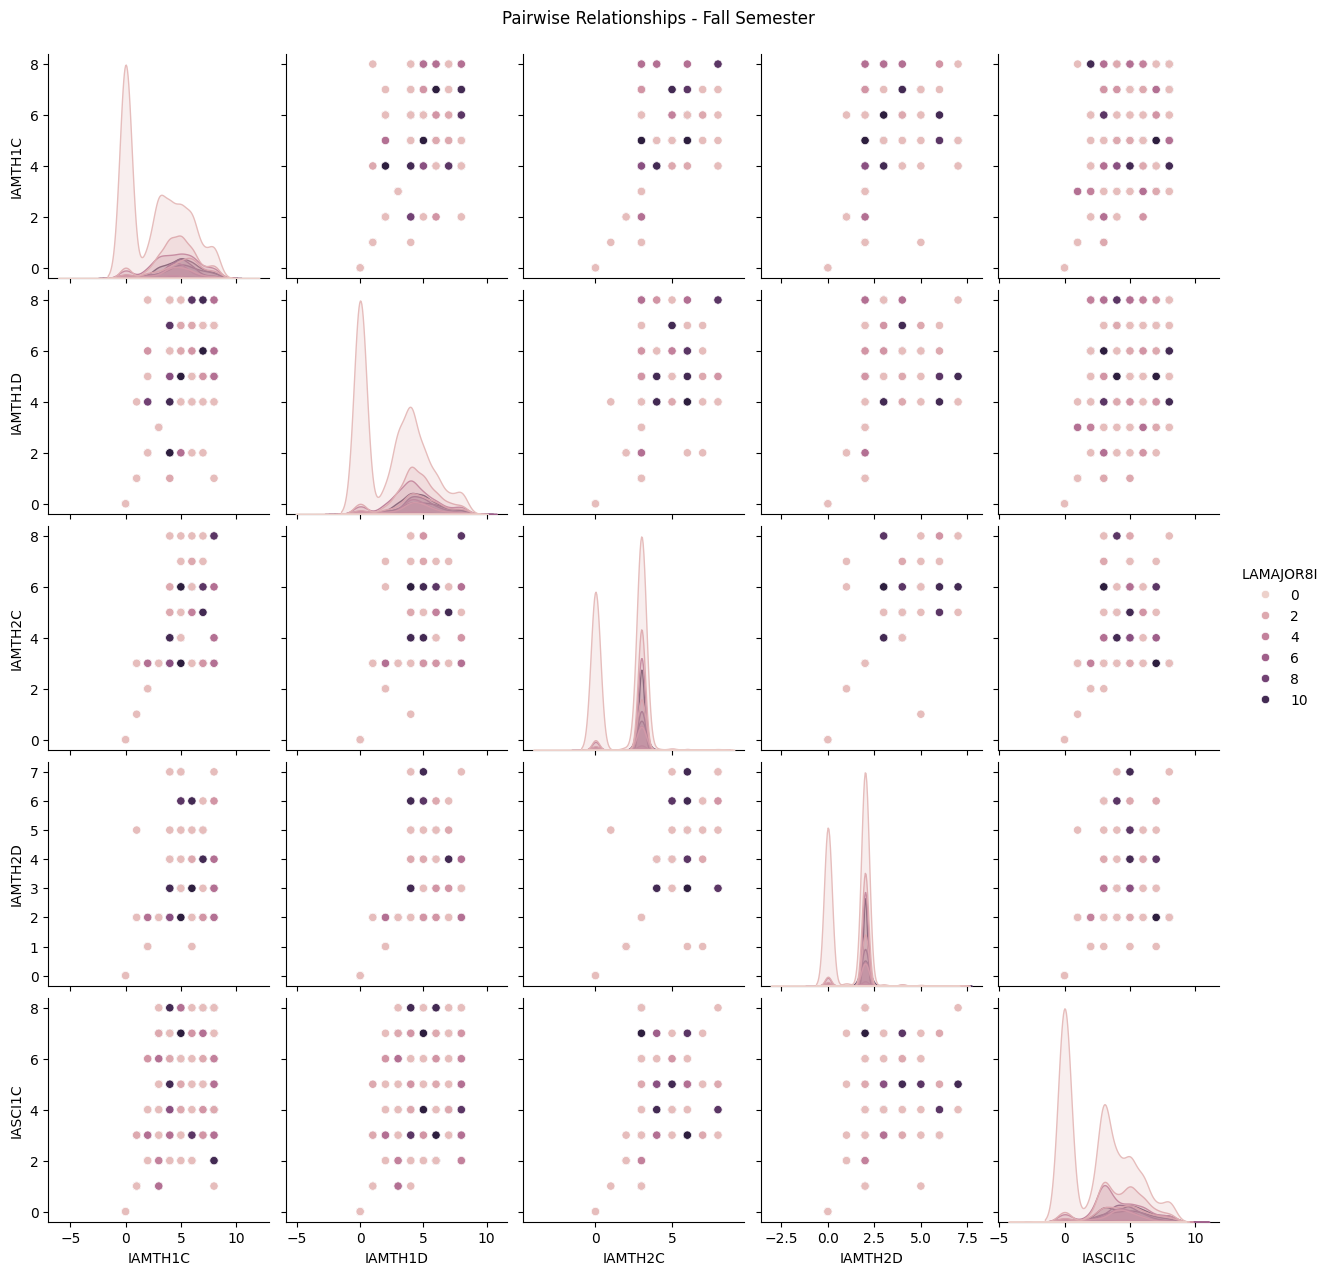

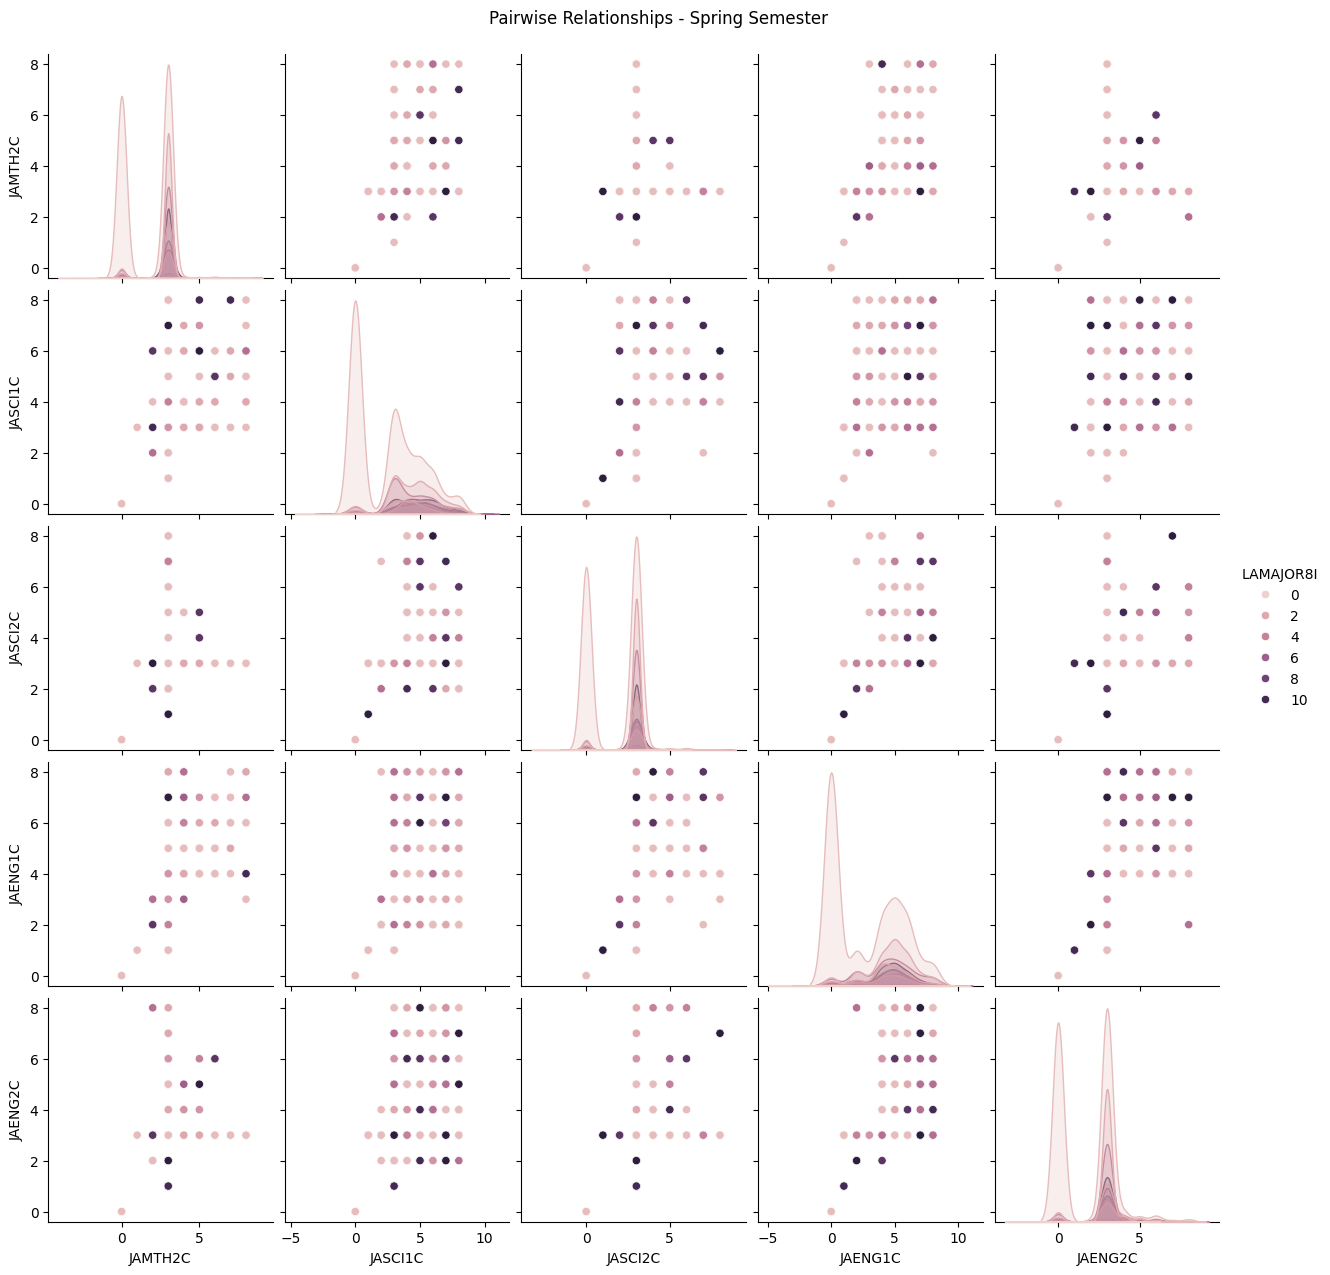

In [8]:
import seaborn as sns

# Combine relevant fall and spring features for visualization
fall_subset = df[fall_variables].copy()
spring_subset = df[spring_variables].copy()

# Add the target variable for visualization purposes
fall_subset['LAMAJOR8I'] = df['LAMAJOR8I']
spring_subset['LAMAJOR8I'] = df['LAMAJOR8I']

# Plot pairwise relationships for a subset of features
subset_features_fall = fall_variables[:5]  # Change as needed
subset_features_spring = spring_variables[:5]  # Change as needed

# Pair plot for Fall Semester
sns.pairplot(fall_subset[subset_features_fall + ['LAMAJOR8I']], hue='LAMAJOR8I')
plt.suptitle('Pairwise Relationships - Fall Semester', y=1.02)
plt.show()

# Pair plot for Spring Semester
sns.pairplot(spring_subset[subset_features_spring + ['LAMAJOR8I']], hue='LAMAJOR8I')
plt.suptitle('Pairwise Relationships - Spring Semester', y=1.02)
plt.show()


<Figure size 1400x700 with 0 Axes>

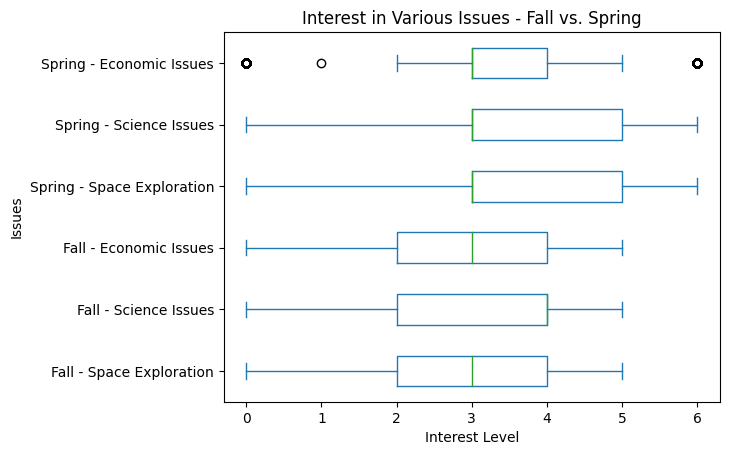

In [9]:
# Assuming you have the columns for interest in various issues
# Visualize the distribution of interests in space exploration, science issues, and economic issues

interest_columns = ['IA8B', 'IA8D', 'IA8E', 'JC3B', 'JC3D', 'JC3E']
interest_labels = ['Space Exploration', 'Science Issues', 'Economic Issues']

# Combine fall and spring interest columns for comparison
interest_df = pd.DataFrame({
    'Fall - Space Exploration': df['IA8B'],
    'Fall - Science Issues': df['IA8D'],
    'Fall - Economic Issues': df['IA8E'],
    'Spring - Space Exploration': df['JC3B'],
    'Spring - Science Issues': df['JC3D'],
    'Spring - Economic Issues': df['JC3E']
})

plt.figure(figsize=(14, 7))
interest_df.plot(kind='box', vert=False)
plt.title('Interest in Various Issues - Fall vs. Spring')
plt.xlabel('Interest Level')
plt.ylabel('Issues')
plt.show()


In [10]:
print(df.columns)


Index(['CASENUM', 'COHORT', 'SCHOOLID', 'STRATA', 'ASCICLS', 'ASCITCH',
       'ASTSEX', 'AMTHCLS', 'AMTHTCH', 'AMTSEX',
       ...
       'PEDUC3', 'MEDSRCE', 'FEDSRCE', 'MOTHOCC', 'FATHOCC', 'POCI',
       'FOCCSRCE', 'MOCCSRCE', 'MOTHSEI', 'FATHSEI'],
      dtype='object', length=11904)


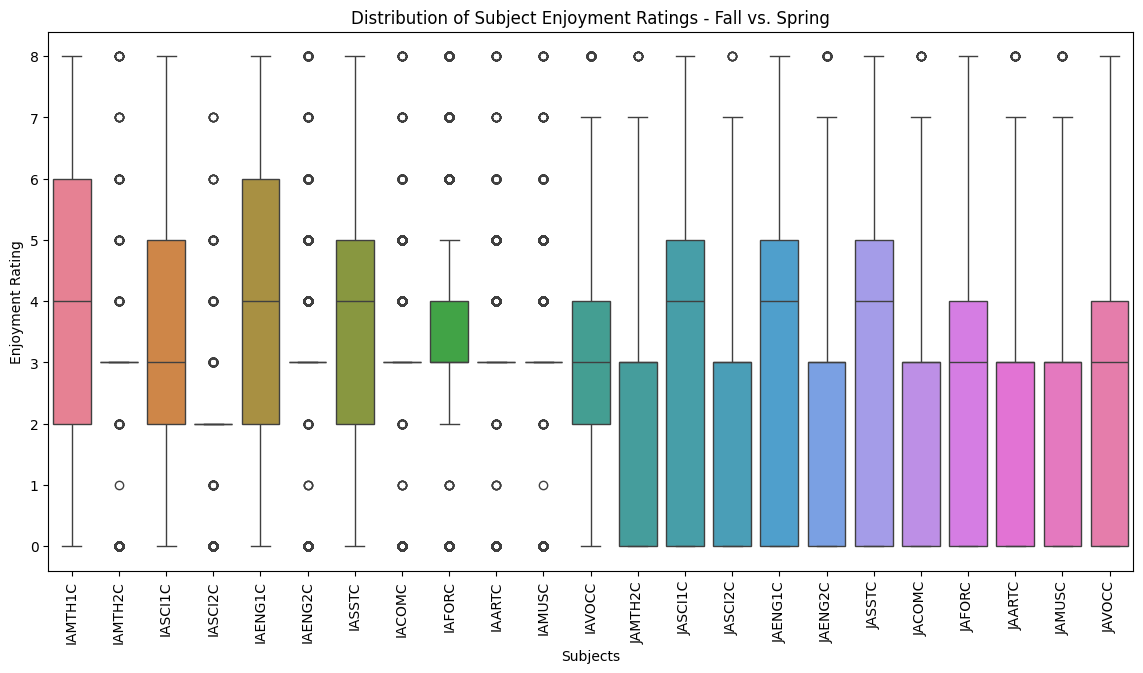

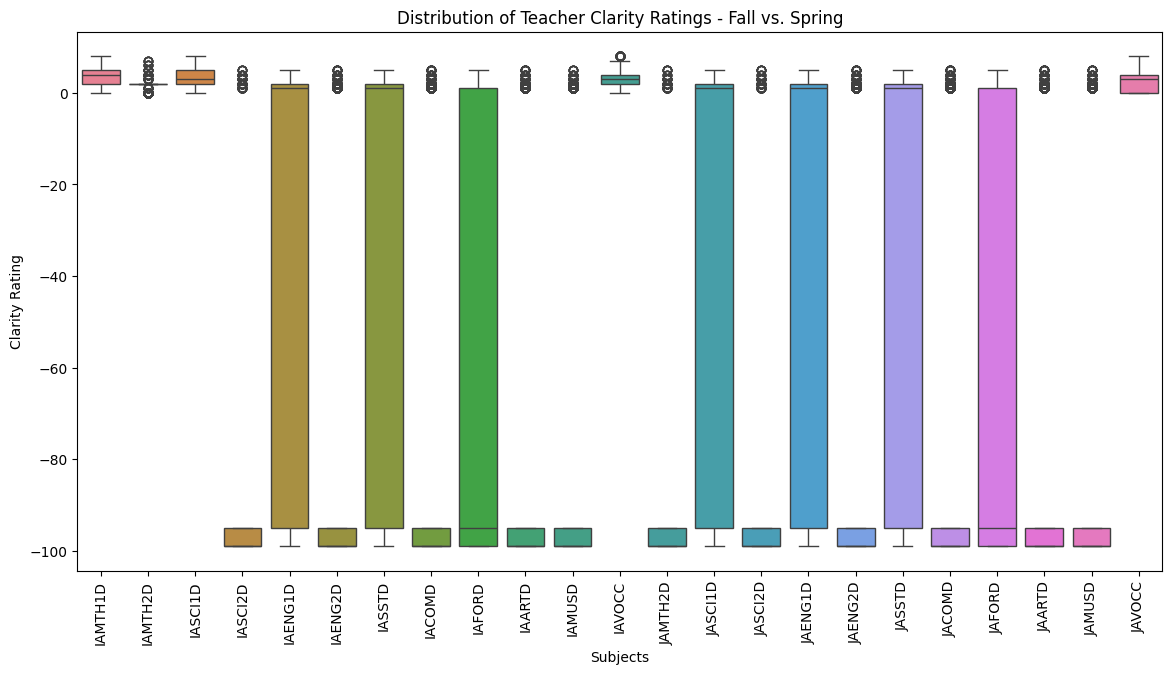

In [12]:
# Example corrected column lists
subject_enjoyment = [
    'IAMTH1C', 'IAMTH2C', 'IASCI1C', 'IASCI2C',
    'IAENG1C', 'IAENG2C', 'IASSTC', 'IACOMC',
    'IAFORC', 'IAARTC', 'IAMUSC', 'IAVOCC',
    'JAMTH2C', 'JASCI1C', 'JASCI2C',
    'JAENG1C', 'JAENG2C', 'JASSTC', 'JACOMC',
    'JAFORC', 'JAARTC', 'JAMUSC', 'JAVOCC'
]

subject_clarity = [
    'IAMTH1D', 'IAMTH2D', 'IASCI1D', 'IASCI2D',
    'IAENG1D', 'IAENG2D', 'IASSTD', 'IACOMD',
    'IAFORD', 'IAARTD', 'IAMUSD', 'IAVOCC',
    'JAMTH2D', 'JASCI1D', 'JASCI2D',
    'JAENG1D', 'JAENG2D', 'JASSTD', 'JACOMD',
    'JAFORD', 'JAARTD', 'JAMUSD', 'JAVOCC'
]

# Create dataframes for enjoyment and clarity
enjoyment_df = df[subject_enjoyment].copy()
clarity_df = df[subject_clarity].copy()

# Convert categorical ratings to numeric values for better visualization
rating_map = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0}
enjoyment_df.replace(rating_map, inplace=True)
clarity_df.replace(rating_map, inplace=True)

# Plot enjoyment ratings
plt.figure(figsize=(14, 7))
sns.boxplot(data=enjoyment_df)
plt.title('Distribution of Subject Enjoyment Ratings - Fall vs. Spring')
plt.xlabel('Subjects')
plt.ylabel('Enjoyment Rating')
plt.xticks(rotation=90)
plt.show()

# Plot clarity ratings
plt.figure(figsize=(14, 7))
sns.boxplot(data=clarity_df)
plt.title('Distribution of Teacher Clarity Ratings - Fall vs. Spring')
plt.xlabel('Subjects')
plt.ylabel('Clarity Rating')
plt.xticks(rotation=90)
plt.show()


Available columns: Index(['CASENUM', 'COHORT', 'SCHOOLID', 'STRATA', 'ASCICLS', 'ASCITCH',
       'ASTSEX', 'AMTHCLS', 'AMTHTCH', 'AMTSEX',
       ...
       'PEDUC3', 'MEDSRCE', 'FEDSRCE', 'MOTHOCC', 'FATHOCC', 'POCI',
       'FOCCSRCE', 'MOCCSRCE', 'MOTHSEI', 'FATHSEI'],
      dtype='object', length=11904)


<Figure size 1400x700 with 0 Axes>

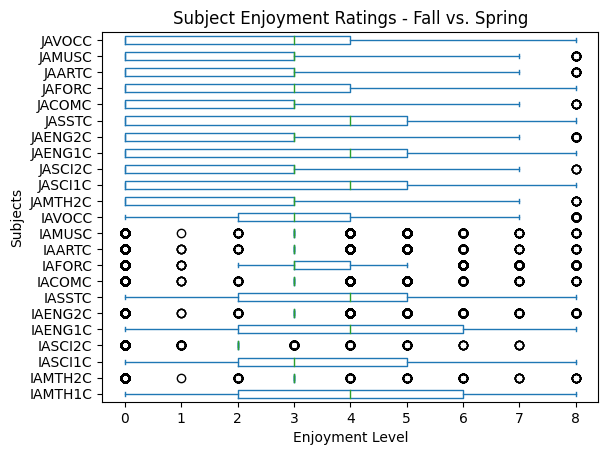

<Figure size 1400x700 with 0 Axes>

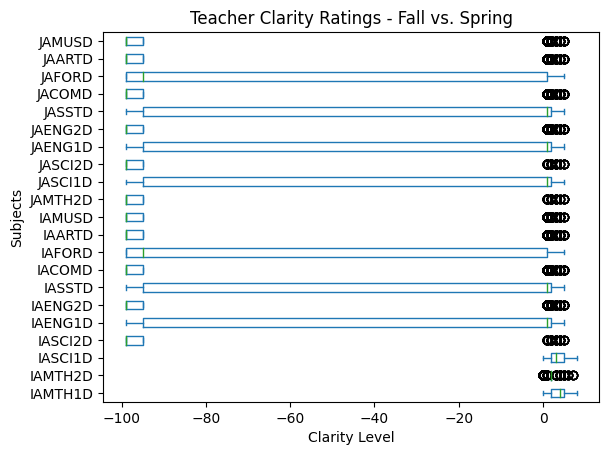

In [13]:
# Verify the columns available in the DataFrame
available_columns = df.columns
print("Available columns:", available_columns)

# Update the clarity columns based on available columns
subject_clarity = [
    'IAMTH1D', 'IAMTH2D', 'IASCI1D', 'IASCI2D',
    'IAENG1D', 'IAENG2D', 'IASSTD', 'IACOMD',
    'IAFORD', 'IAARTD', 'IAMUSD', 'IAVOCCD',  # Check these columns
    'JAMTH2D', 'JASCI1D', 'JASCI2D',
    'JAENG1D', 'JAENG2D', 'JASSTD', 'JACOMD',
    'JAFORD', 'JAARTD', 'JAMUSD', 'JAVOCCD'
]

# Filter out columns that are not in the DataFrame
subject_clarity = [col for col in subject_clarity if col in available_columns]

# Create dataframes for enjoyment and clarity
enjoyment_df = df[subject_enjoyment].copy()
clarity_df = df[subject_clarity].copy()

# Plot enjoyment ratings
plt.figure(figsize=(14, 7))
enjoyment_df.plot(kind='box', vert=False)
plt.title('Subject Enjoyment Ratings - Fall vs. Spring')
plt.xlabel('Enjoyment Level')
plt.ylabel('Subjects')
plt.show()

# Plot clarity ratings
plt.figure(figsize=(14, 7))
clarity_df.plot(kind='box', vert=False)
plt.title('Teacher Clarity Ratings - Fall vs. Spring')
plt.xlabel('Clarity Level')
plt.ylabel('Subjects')
plt.show()


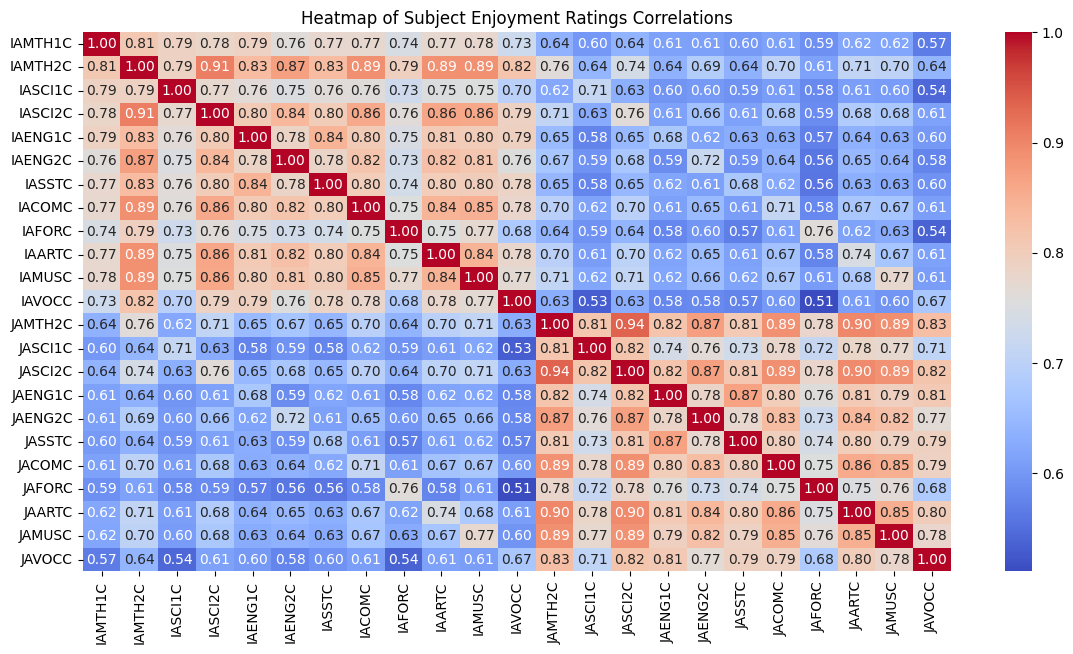

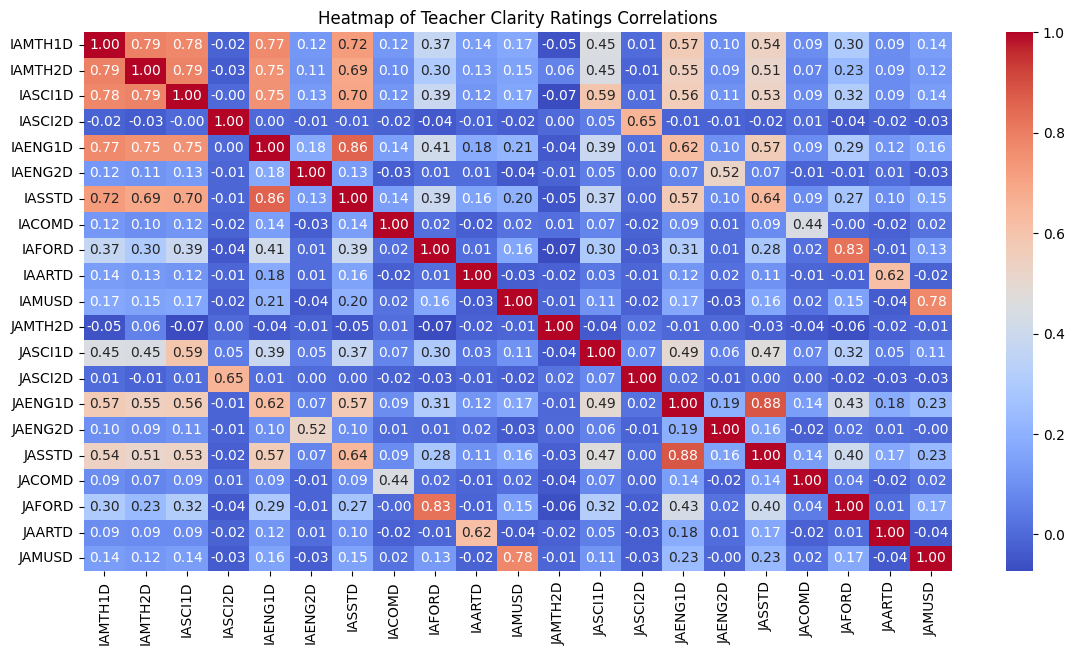

In [14]:
# Plot heatmap for enjoyment ratings
plt.figure(figsize=(14, 7))
sns.heatmap(enjoyment_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Subject Enjoyment Ratings Correlations')
plt.show()

# Plot heatmap for clarity ratings
plt.figure(figsize=(14, 7))
sns.heatmap(clarity_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Teacher Clarity Ratings Correlations')
plt.show()


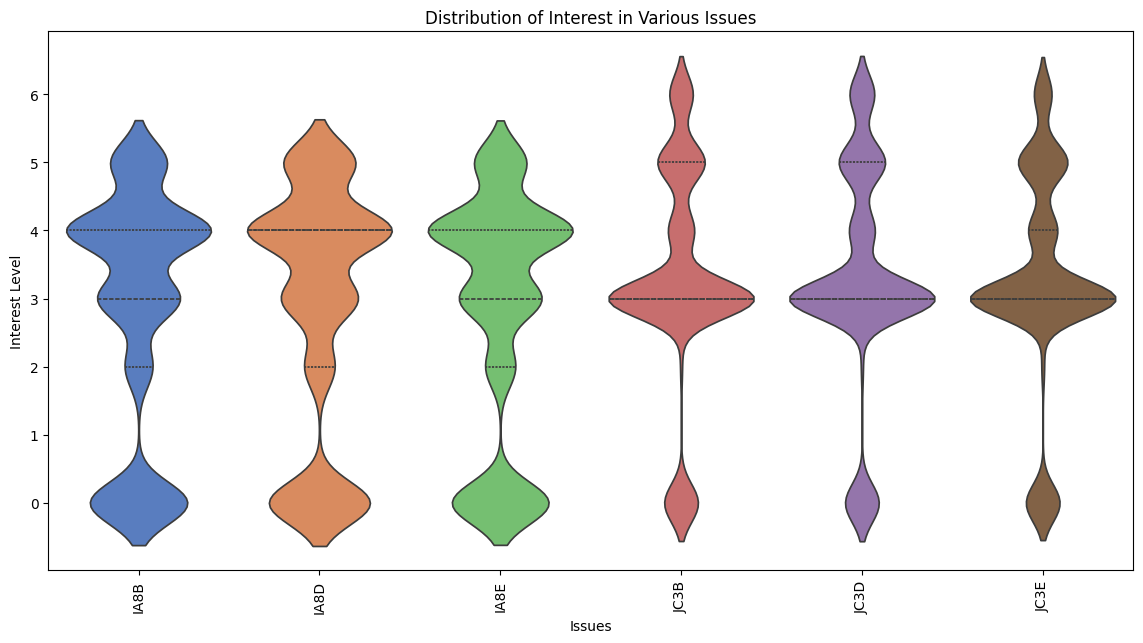

In [15]:
# Define interest variables
interest_vars = ['IA8B', 'IA8D', 'IA8E', 'JC3B', 'JC3D', 'JC3E']

# Create dataframe for interest variables
interest_df = df[interest_vars].copy()

# Convert categorical interest levels to numeric values for better visualization
interest_map = {'Very Interested': 4, 'Interested': 3, 'Somewhat Interested': 2, 'Not Interested': 1}
interest_df.replace(interest_map, inplace=True)

# Plot violin plot for interest levels
plt.figure(figsize=(14, 7))
sns.violinplot(data=interest_df, inner='quartile', palette='muted')
plt.title('Distribution of Interest in Various Issues')
plt.xlabel('Issues')
plt.ylabel('Interest Level')
plt.xticks(rotation=90)
plt.show()


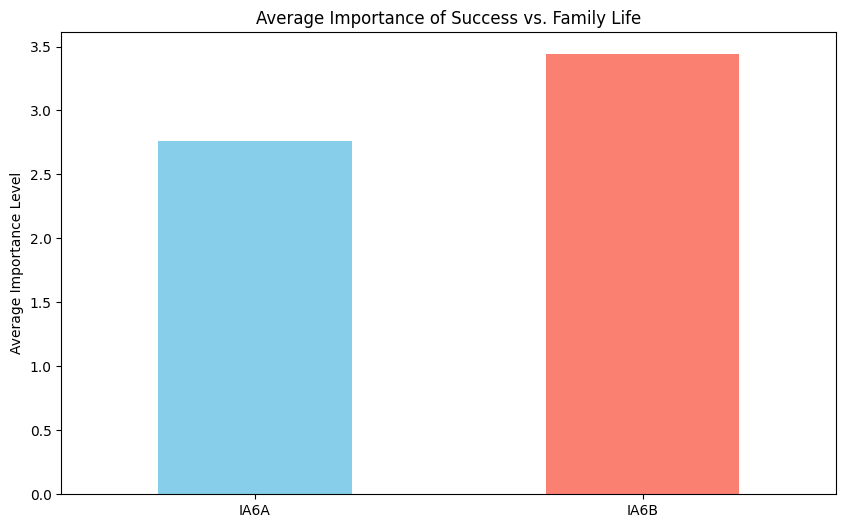

In [16]:
# Define importance variables
importance_vars = ['IA6A', 'IA6B']

# Create dataframe for importance variables
importance_df = df[importance_vars].copy()

# Convert categorical importance levels to numeric values for better visualization
importance_map = {'Very Important': 4, 'Important': 3, 'Somewhat Important': 2, 'Not Important': 1}
importance_df.replace(importance_map, inplace=True)

# Plot bar plot for importance levels
plt.figure(figsize=(10, 6))
importance_df.mean().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Importance of Success vs. Family Life')
plt.ylabel('Average Importance Level')
plt.xticks(rotation=0)
plt.show()
